In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from utils import *


# Loading the checkpoints

## CIFAR-10 Dataset


In [26]:
# Load the checkpoints for all models of interest
sgd_cifar10 = torch.load(
    os.path.join(
        '../checkpoints/cifar10', 
        's-fc_beta_0.0_lr_0.1_lambda_0.0_ep_400/sfc_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

beta_50_cifar10 = torch.load(
    os.path.join(
        '../checkpoints/cifar10',
        's-fc_beta_50.0_lr_0.1_lambda_2e-05_ep_400/sfc_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

slocal_sgd_cifar10 = torch.load(
    os.path.join(
        '../checkpoints/cifar10',
        's-local_beta_0.0_lr_0.1_scheduler_lambda_0.0_ep_20',
        'slocal_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

print(slocal_sgd_cifar10.keys())

dict_keys(['epoch', 'model_state_dict', 'val_loss'])


## SVHN Dataset

In [27]:
sgd_shvn = torch.load(
    os.path.join(
        '../checkpoints/svhn', 
        's-fc_beta_0.0_lr_0.1s-fc_beta_0.0_lr_0.1_scheduler_lambda_0.0',
        'sfc_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

beta_50_svhn = torch.load(
    os.path.join(
        '../checkpoints/svhn',
        's-fc_beta_50.0_lr_0.1s-fc_beta_50.0_lr_0.1_scheduler_lambda_2e-05',
        'sfc_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

slocal_sgd_svhn = torch.load(
    os.path.join(
        '../checkpoints/svhn',
        's-local_beta_0.0_lr_0.1s-local_beta_0.0_lr_0.1_scheduler_lambda_0.0',
        'slocal_checkpoint.pt'
        ),
    map_location=torch.device('cpu')
    )

print(slocal_sgd_cifar10.keys())

dict_keys(['epoch', 'model_state_dict', 'val_loss'])


# Recreating Figure 4

## Plotting functions

In [28]:
def plot_sfc_filters(batch_filters, abs=False, axs=None, figname=None):
    """
    Function for plotting the filters of an S-FC model.
    We plot a 2x4 grid of randomly chosen filters.
    """
    if axs is None:
        fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4*2, 2*2))

    random_filter_inds = np.random.randint(
        low=0, high=len(batch_filters), size=(2 * 4)
        )
    for i in range(2): 
        for j in range(4):
            filter = batch_filters[random_filter_inds[4 * i + j]]
            
            if abs:
                filter = filter.abs()
            filter = (filter - filter.min()) / (filter.max() - filter.min())
            filter_reshaped = filter.view(3, 32, 32)

            axs[i][j].imshow(filter_reshaped.permute(1, 2, 0).numpy())
            axs[i][j].axis('off')

    if figname is not None:
        plt.tight_layout()
        plt.savefig(figname)  
    plt.show()



In [29]:
def calc_coords_in(i, j, kernel_size=9, stride=2):
    """
    Given a kernel size and stride of a CNN filter, as well pixel coordinates in
    the output channel, this function approximates the input pixel coordinates. 
    """
    return (i*stride + int(kernel_size/2), j*stride + int(kernel_size/2))
    

def plot_slocal_single_filter(batch_filters, coords_out, ax=None):
    """
    Given the parameters of an S-LOCAL model and the desired coordinates of the 
    pixel in the output channel, this funciton plots that 
    filter in the input channel space.
    """
    coords_in = calc_coords_in(coords_out[0], coords_out[1])

    filter = batch_filters[0, 0, : , coords_out[0], coords_out[1], : ]
    filter = filter.view(3, 9, 9).permute(1, 2, 0)

    filter_img = torch.zeros(32, 32, 3)

    filter_img[
        coords_in[0]-int(9/2) : coords_in[0]+int(9/2)+1, 
        coords_in[1]-int(9/2) : coords_in[1]+int(9/2)+1, 
        : 
        ] = filter 

    if ax is not None:
        ax.imshow((filter_img * 255).numpy().astype(np.uint8))
        ax.axis('off')
    else:
        plt.imshow(filter_img)


def plot_slocal_filters(batch_filters, figname=None):
    """
    Function that creates a 2x4 grid of locally-connected filter plots.
    """
    x_inds = np.random.randint(low=0, high=12, size=(2, 4))
    y_inds = np.random.randint(low=0, high=12, size=(2, 4))

    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4*2, 2*2))

    for i in range(2):
        for j in range(4):
            x, y = x_inds[i, j], y_inds[i, j]

            plot_slocal_single_filter(batch_filters, (x, y), axs[i][j])    

    if figname is not None:
        plt.tight_layout()
        plt.savefig(figname)  


## Results - CIFAR-10


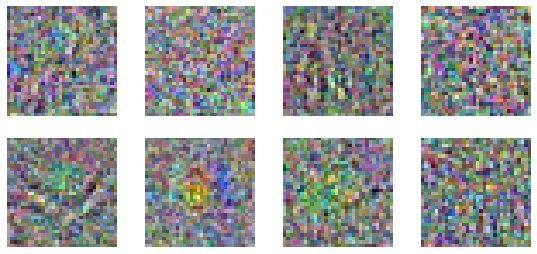

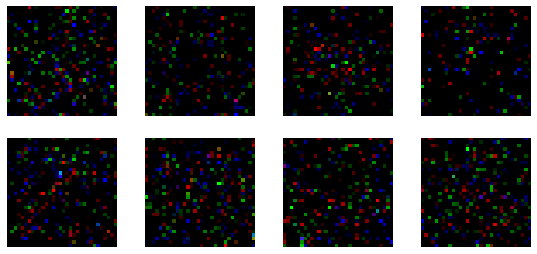

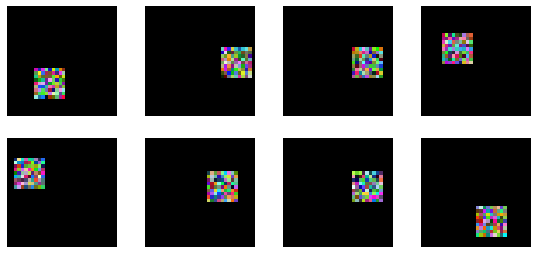

In [44]:
plot_sfc_filters(
    sgd_cifar10['model_state_dict']['fc_layers.0.layers.0.weight'], 
    figname='../plots/cifar10_sfc_sgd_filters'
    )
plot_sfc_filters(
    beta_50_cifar10['model_state_dict']['fc_layers.0.layers.0.weight'], 
    figname='../plots/cifar10_sfc_beta_50_filters', abs=True
    )

plot_slocal_filters(
    slocal_sgd_cifar10['model_state_dict']['local_layer.layers.0.weight'],
    figname='../plots/cifar10_slocal_filters'
    )

## Results - SVHN


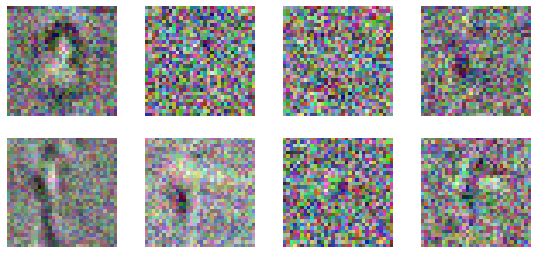

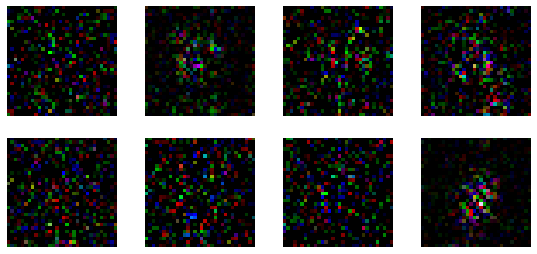

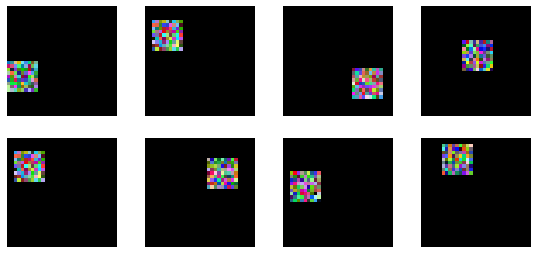

In [45]:
plot_sfc_filters(
    sgd_shvn['model_state_dict']['fc_layers.0.layers.0.weight'], 
    figname='../plots/svhn_sfc_sgd_filters'
    )
plot_sfc_filters(
    beta_50_svhn['model_state_dict']['fc_layers.0.layers.0.weight'], 
    figname='../plots/svhn_sfc_beta_50_filters', abs=True
    )

plot_slocal_filters(
    slocal_sgd_svhn['model_state_dict']['local_layer.layers.0.weight'],
    figname='../plots/svhn_slocal_filters'
    )

# Recreating Table 2

In [32]:
sgd_cifar10_metrics = torch.load(
    os.path.join(
        '../checkpoints/cifar10',
        's-fc_beta_0.0_lr_0.1_lambda_0.0_ep_400/sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

beta_0_cifar10_metrics = torch.load(
    os.path.join(
        '../checkpoints/cifar10',
        's-fc_beta_0.0_lr_0.1_lambda_2e-05_ep_400/sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

beta_1_cifar10_metrics = torch.load(
    os.path.join(
        '../checkpoints/cifar10',
        's-fc_beta_1.0_lr_0.1_lambda_2e-05_ep_400/sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

beta_50_cifar10_metrics = torch.load(
    os.path.join(
        '../checkpoints/cifar10', 
        's-fc_beta_50.0_lr_0.1_lambda_2e-05_ep_400/sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

In [33]:
metrics_dict = {
    'SGD': sgd_cifar10_metrics, 'Beta = 0': beta_0_cifar10_metrics,
    'Beta = 1': beta_1_cifar10_metrics, 'Beta = 50': beta_50_cifar10_metrics
    }

for model_str, metrics in metrics_dict.items():
    print(
        model_str, ' ---- ', 
        f"{np.round(float(metrics['test'].get_accuracy()), 2)}%"
        )



SGD  ----  45.07%
Beta = 0  ----  49.32%
Beta = 1  ----  51.1%
Beta = 50  ----  48.54%


# Recreating Figure 3

## Loading the metrics

In [34]:
fig3_cifar10_metrics = torch.load(
    os.path.join(
        '../checkpoints/figure_3/cifar10_50',
        's-fc_beta_50.0_lr_0.1s-fc_beta_50.0_lr_0.1_scheduler_lambda_2e-05',
        'sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

fig3_svhn_metrics = torch.load(
    os.path.join(
        '../checkpoints/figure_3/svhn_50',
        's-fc_beta_50.0_lr_0.1s-fc_beta_50.0_lr_0.1_scheduler_lambda_2e-05',
        'sfc_metrics_per_epoch.pt'
        ),
    map_location=torch.device('cpu')
    )

In [35]:
def plot_non_zero_counts(metrics, layer_str, ax, show_plot, label, clr ,title=None):
    """
    Function that plots the number of non-zero parameters over epochs, 
    given the desired layer number (1, 2, 3)
    """
    to_plot = []
    for i in range(100):
        to_plot.append(metrics[i]['train'].non_zero_params_cnts[layer_str][0])

    ax.plot(to_plot, label=label, color=clr)

    ax.legend()
    if title is not None:
        ax.set_title(title)
    ax.grid(visible=True, axis='both')
    if show_plot:
        plt.show()

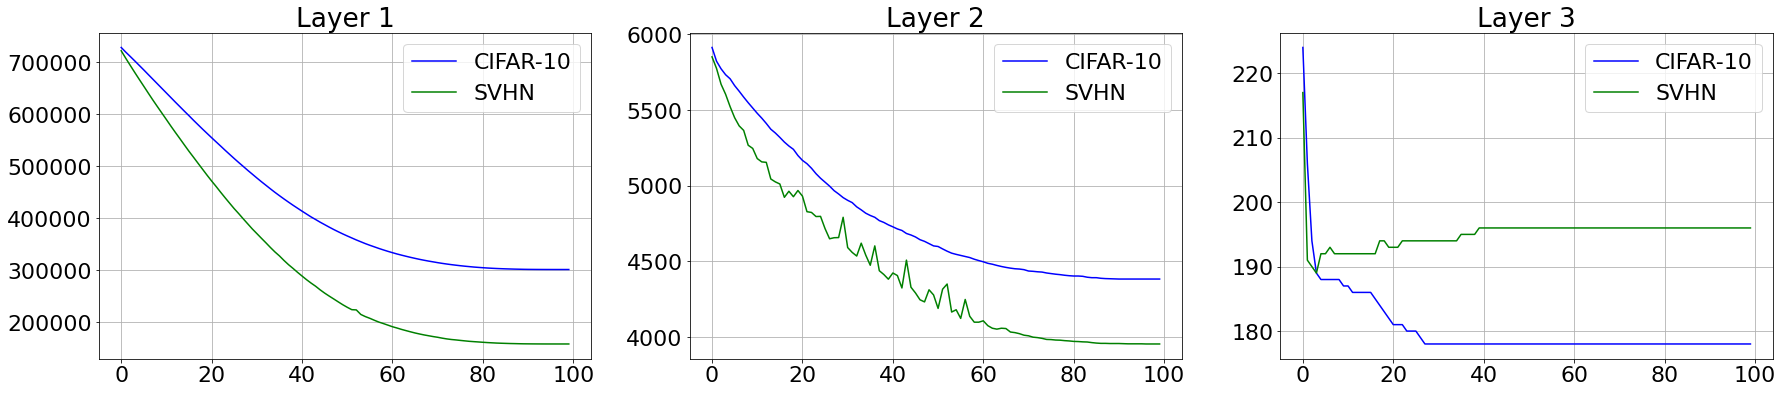

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(30, 6))
plt.rcParams.update({'font.size': 22})

# Layer 1
plot_non_zero_counts(
    fig3_cifar10_metrics, '1', axs[0], False, 'CIFAR-10', 'b', 'Layer 1'
    )
plot_non_zero_counts(fig3_svhn_metrics, '1', axs[0], False, 'SVHN', 'g')

# Layer 2
plot_non_zero_counts(
    fig3_cifar10_metrics, '2', axs[1], False, 'CIFAR-10', 'b', 'Layer 2'
    )
plot_non_zero_counts(fig3_svhn_metrics, '2', axs[1], False, 'SVHN', 'g')

# Layer 3
plot_non_zero_counts(
    fig3_cifar10_metrics, '3', axs[2], False, 'CIFAR-10', 'b', 'Layer 3'
    )
plot_non_zero_counts(fig3_svhn_metrics, '3', axs[2], False, 'SVHN', 'g')

plt.savefig('../plots/figure_3')
plt.show()

